# Training Linear Models

## Imports and Parameters

In [30]:
import pandas as pd
import numpy as np
from pathlib import Path

In [31]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [32]:
# Reproducibility
np.random.seed(42)

# Closed form solution for linear regression

Text(0, 0.5, '$y$')

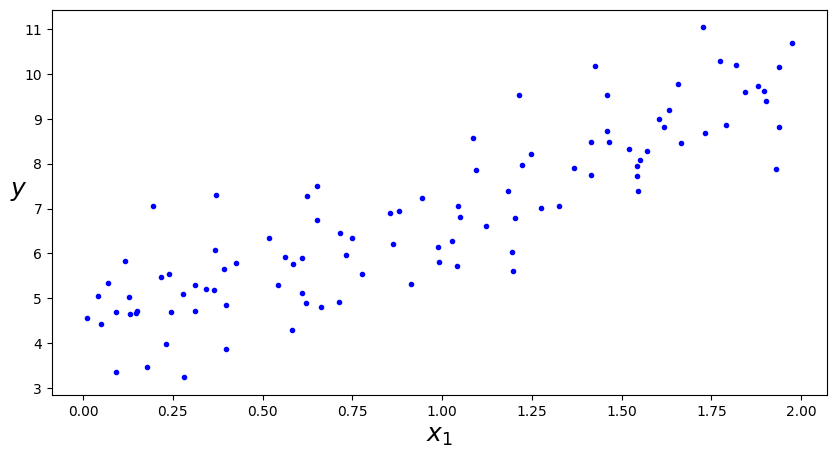

In [33]:
# Generate some data to test the equation

m = 100 # number of instances
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

In [34]:
# Computing the best theta using the Normal Equation

from sklearn.preprocessing import add_dummy_feature
X_b = add_dummy_feature(X) 		# add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [35]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [36]:
# Making predictions using theta_best
X_new = np.array([[0], [2]])	# two instances at the extremes
X_new_b = add_dummy_feature(X_new)		# add x0 = 1 to each instance
y_predict = X_new_b @ theta_best

In [37]:
y_predict

array([[4.21509616],
       [9.75532293]])

In [38]:
x_orig = np.linspace(0, 2, 100)
y_orig = 4 + 3 * x_orig

y_bad = 2 + 2 * x_orig

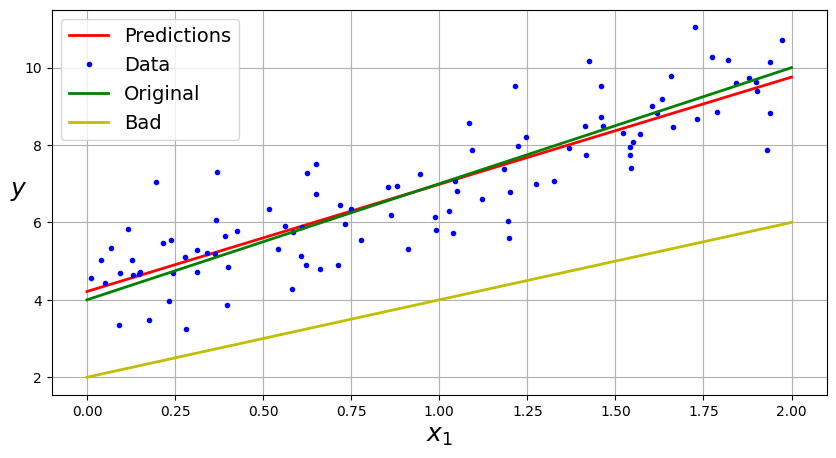

In [39]:
# Plot the model
plt.figure(figsize=(10, 5))
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.", label="Data")
plt.plot(x_orig, y_orig, "g-", linewidth=2, label="Original")
plt.plot(x_orig, y_bad, "y-", linewidth=2, label="Bad")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.grid()
plt.legend()

In [40]:
# Using Scikit-Learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
print(f"Using Scikit-Learn:")
print(f"Intercept: {lin_reg.intercept_.item():.3f}; Slope:{ lin_reg.coef_.item():.3f}")
preds = lin_reg.predict(X_new)
print(f"Points (x, y): (0, {preds[0].item():.3f}); (2, {preds[1].item():.3f})")
print(f"Using Normal Equation:")
print(f"Intercept: {theta_best[0].item():.3f}; Slope:{ theta_best[1].item():.3f}")
print(f"Points (x, y): (0, {y_predict[0].item():.3f}); (2, {y_predict[1].item():.3f})")

Using Scikit-Learn:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)
Using Normal Equation:
Intercept: 4.215; Slope:2.770
Points (x, y): (0, 4.215); (2, 9.755)


Taking a look at the cost function for different theta values.

In [41]:
# Dividing theta paramters into intercept and slope
# slope = 2.77; intercept = 4.22
intercept, slope = theta_best[0].item(), theta_best[1].item()

slopes = np.linspace(slope - 1, slope + 1, 100)
intercepts = np.linspace(intercept - 2, intercept + 2, 100)

# Compute the cost function for each combination of slope and intercept
def linear_function(x, slope, intercept):
	return slope * x + intercept

def MSE(y, y_pred):
	return np.mean((y - y_pred) ** 2)

costs = np.zeros((100, 100))
for i, s in enumerate(slopes):
	for j, inter in enumerate(intercepts):
		y_pred = linear_function(X, s, inter)
		costs[i, j] = MSE(y, y_pred)

In [42]:
def find_value(array, value):
	return np.abs(array - value).argmin()

best_slope_idx = find_value(slopes, slope)
best_intercept_idx = find_value(intercepts, intercept)

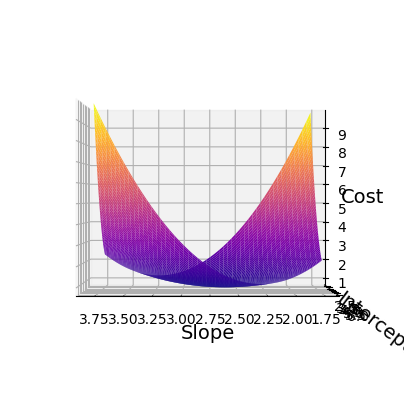

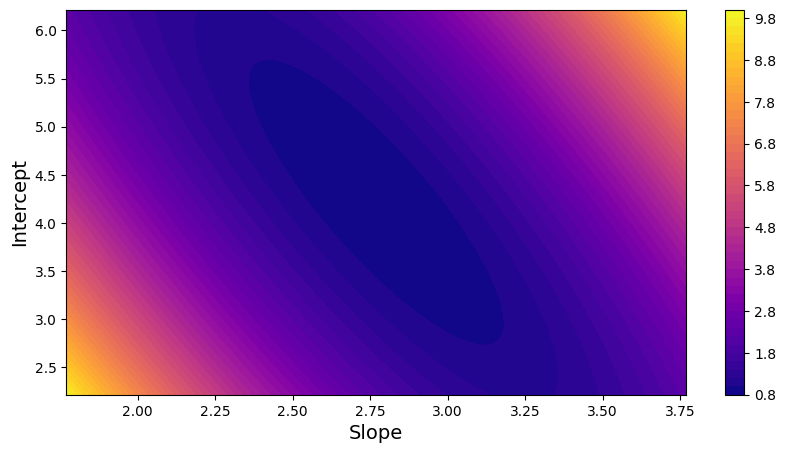

In [43]:
# Plot the cost function in 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111, projection='3d')
X_mesh, Y_mesh = np.meshgrid(slopes, intercepts)
ax.plot_surface(X_mesh, Y_mesh, costs, cmap='plasma')
ax.view_init(elev=0, azim=90)
ax.set_xlabel('Slope')
ax.set_ylabel('Intercept')
ax.set_zlabel('Cost')
plt.show()


# Plot the cost function in 2D
plt.figure(figsize=(10, 5))
plt.contourf(X_mesh, Y_mesh, costs, levels=50, cmap='plasma')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.colorbar()
plt.show()

In [44]:
width = 3
costs[best_slope_idx-width:best_slope_idx+width, best_intercept_idx]

array([0.81585223, 0.81206112, 0.80927786, 0.80750245, 0.80673488,
       0.80697517])

In [45]:
with open("../Test/data.dat", 'w') as f:
	f.write("Slope, Intercept, Cost\n")
	for i in range(100):
		for j in range(100):
			f.write(f"{slopes[i]}, {intercepts[j]}, {costs[i, j]}\n")
	

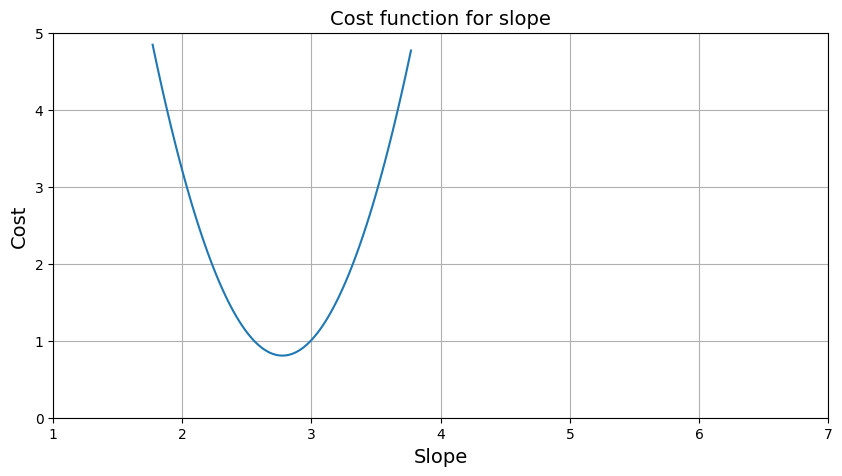

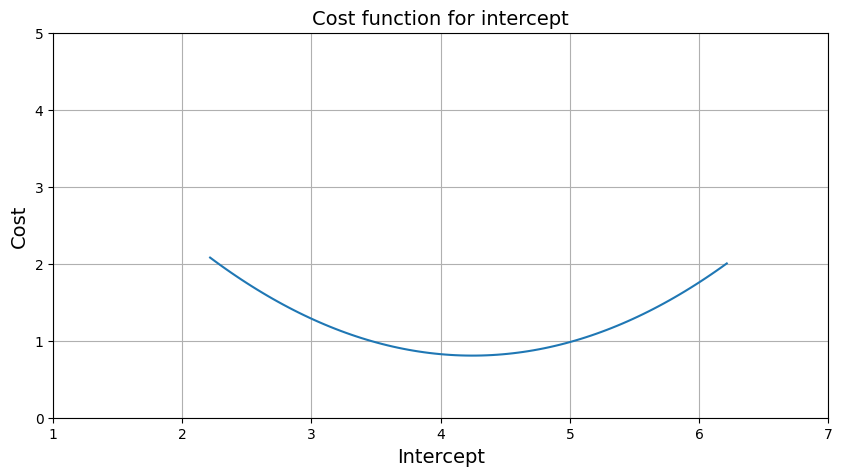

In [46]:
# Plot cost function for slope and intercept separately

x_range = (1, 7)
y_range = (0, 5)

plt.figure(figsize=(10, 5))
plt.plot(slopes, costs[best_slope_idx, :])
plt.xlabel('Slope')
plt.xlim(x_range)
plt.ylabel('Cost')
plt.ylim(y_range)
plt.title('Cost function for slope')
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(intercepts, costs[:, best_intercept_idx])
plt.xlabel('Intercept')
plt.xlim(x_range)
plt.ylabel('Cost')
plt.ylim(y_range)
plt.title('Cost function for intercept')
plt.grid()
plt.show()

# Gradient descent

In [47]:
# A simple implementation of gradient descent

eta = 0.1 		# learning rate
epochs = 10000	# number of iterations
m = len(X_b) 	# number of instances

# Initialize theta at a random value
np.random.seed(42)
theta = np.random.randn(2, 1)

def batch_GD(X, y, eta, epochs):
	batch_theta_path = []
	theta = np.random.randn(2, 1)
	for epoch in range(epochs):
		gradients = 2/m * X_b.T @ (X_b @ theta - y)
		theta = theta - eta * gradients
		batch_theta_path.append(theta)
	return theta, batch_theta_path

theta_batch, theta_path_batch = batch_GD(X_b, y, eta, epochs)

print(f"Using Gradient Descent:")
print(f"Values for the generated data: ")
print("Intercept: 4; Slope: 3")
print(f"Intercept: {theta_batch[0].item():.3f}; Slope:{ theta_batch[1].item():.3f}")

Using Gradient Descent:
Values for the generated data: 
Intercept: 4; Slope: 3
Intercept: 4.215; Slope:2.770


# Stochastic Gradient Descent

In [48]:
n_epochs = 50
t0, t1 = 5, 50 	# learning schedule hyperparameters
m = len(X_b)

def learning_schedule(t):
	return t0 / (t + t1)

def stocastic_GD(X, y, theta, n_epochs, random_state=42):
	np.random.seed(random_state)
	theta = np.random.randn(2, 1)
	theta_path_sgd = []
	for epoch in range(n_epochs):
		for i in range(m):
			random_index = np.random.randint(m)
			xi = X_b[random_index:random_index+1]
			yi = y[random_index:random_index+1]
			gradients = 2 * xi.T @ (xi @ theta - yi)
			eta = learning_schedule(epoch * m + i)
			theta = theta - eta * gradients
			theta_path_sgd.append(theta)

	return theta, theta_path_sgd

theta_SGD, theta_path_sgd = stocastic_GD(X_b, y, theta, n_epochs)

In [49]:
theta_SGD

array([[4.21076011],
       [2.74856079]])

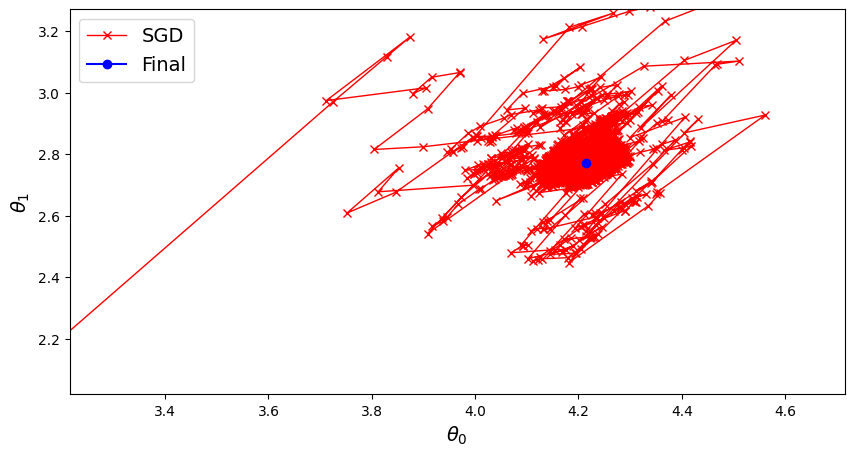

In [50]:
# Thetas path
theta_path_sgd = np.array(theta_path_sgd)

plt.figure(figsize=(10, 5))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-x", linewidth=1, label="SGD")
plt.plot(theta_best[0], theta_best[1], "b-o", label="Final")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.xlim(theta_best[0]-1, theta_best[0]+0.5)
plt.ylim(theta_best[1]-0.75, theta_best[1]+0.5)
plt.legend()

In [51]:
# Implementing this using sci-kit learn
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None,
					   eta0=0.01, n_iter_no_change=100, random_state=42)

# .ravel() is used to convert the y array to a 1D array
# y.shape = (100, 1) -> y.ravel().shape = (100,)
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [52]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

# Mini-batch Gradient Descent

In [53]:
# Mix of Batch and Stochastic Gradient Descent

def mini_bath_GD(X, y, eta=0.1, n_epochs=50, batch_size=20):
	theta = np.random.randn(2, 1)
	theta_path_mgd = []
	m = len(X_b)

	for epoch in range(n_epochs):
		shuffled_indices = np.random.permutation(m)
		X_b_shuffled = X_b[shuffled_indices]
		y_shuffled = y[shuffled_indices]

		for i in range(0, m, batch_size):
			xi = X_b_shuffled[i:i+batch_size]
			yi = y_shuffled[i:i+batch_size]
			gradients = 2/batch_size * xi.T @ (xi @ theta - yi)
			# eta = learning_schedule(epoch * m + i)
			theta = theta - eta * gradients
			theta_path_mgd.append(theta)

	return theta, theta_path_mgd

In [54]:
theta_mini, theta_path_mgd = mini_bath_GD(X_b, y)

In [55]:
def compare_theta_paths(theta_best, theta_paths, line_style , labels, figsize=(10, 5), rel_xlim=(-1, 0.5), rel_ylim=(-0.75, 0.5)):
	
	plt.figure(figsize=figsize)
	for i, path in enumerate(theta_paths):
		path = np.array(path)
		plt.plot(path[:, 0], path[:, 1], line_style[i], linewidth=1, label=labels[i], alpha=0.5)
	plt.plot(theta_best[0], theta_best[1], "k-o", label="Final")
	plt.xlabel(r"$\theta_0$")
	plt.ylabel(r"$\theta_1$")
	plt.xlim(theta_best[0]+rel_xlim[0], theta_best[0]+rel_xlim[1])
	plt.ylim(theta_best[1]+rel_ylim[0], theta_best[1]+rel_ylim[1])
	plt.legend()
	plt.show()

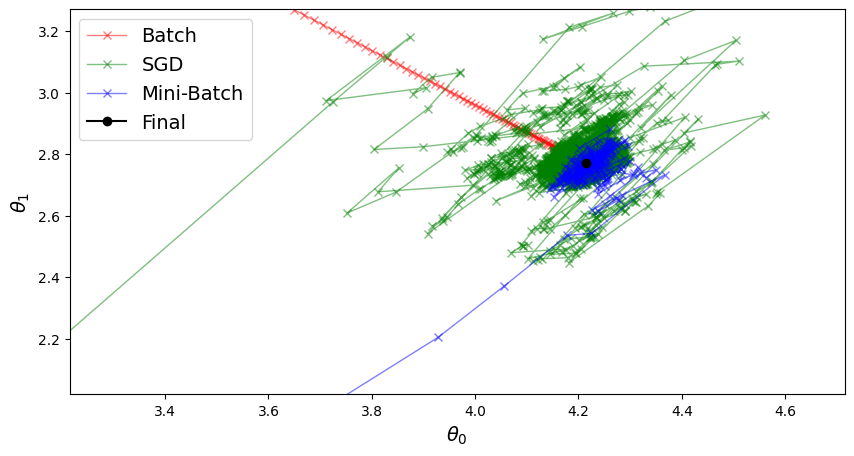

In [56]:
labels = ["Batch", "SGD", "Mini-Batch"]
color_maps = ["r-x", "g-x", "b-x"]
theta_paths = [theta_path_batch, theta_path_sgd, theta_path_mgd]

compare_theta_paths(theta_best, theta_paths, color_maps, labels)

## Polynomial Regression

In [57]:
# Generate some data using a polynomial function
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

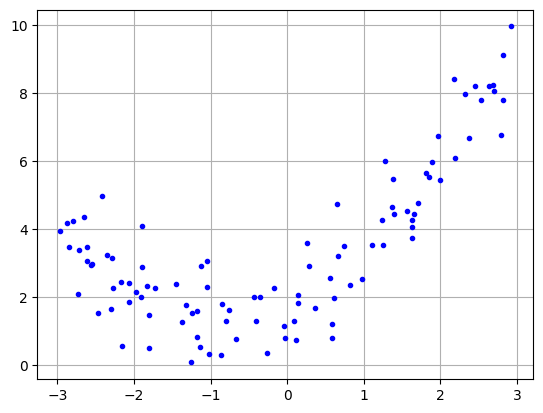

In [58]:
plt.plot(X, y, "b.")
plt.grid()

In [59]:
# We simply add powers of the data as new features
# Then, linear regression can be applied to the new data
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [60]:
print(f"Original data: {X[0].item()}")
print(f"Transformed data: {X_poly[0]}")

Original data: -0.752759286915825
Transformed data: [-0.75275929  0.56664654]


In [61]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

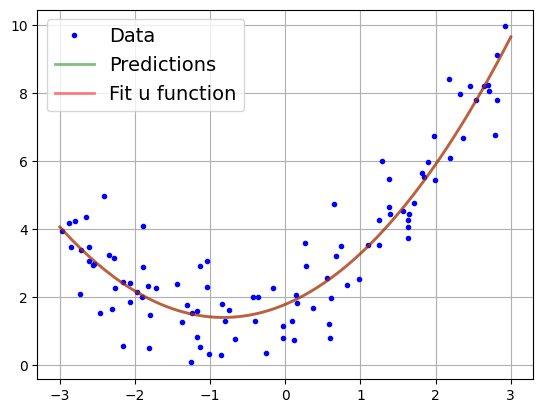

In [62]:
def polinomial_function(x, theta):
	return theta[0] + theta[1] * x + theta[2] * x**2

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

y_new = polinomial_function(X_new, [lin_reg.intercept_.item(), lin_reg.coef_[0][0].item(), lin_reg.coef_[0][1].item()])

X_new_poly = poly_features.transform(X_new)
y_preds = lin_reg.predict(X_new_poly)

plt.plot(X, y, "b.", label='Data')
plt.plot(X_new, y_preds, "g-", linewidth=2, label='Predictions', alpha=0.5)
plt.plot(X_new, y_new, "r-", linewidth=2, label='Fit u function', alpha=0.5)
plt.grid()
plt.legend()

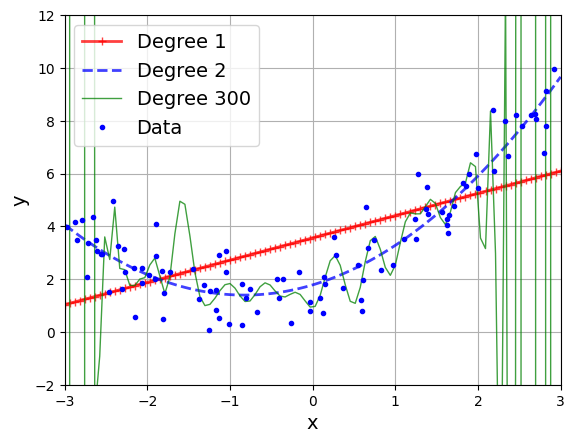

In [63]:
# We could use a higher degree polynomial to fit the data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def plot_poly_fit(X, y, X_new, degrees=(1, 2, 300), styles=('r-+', 'b--', 'g-'), widths=(2, 2, 1)):

	for degree, style, width in zip(degrees, styles, widths):

		poly_features = PolynomialFeatures(degree=degree, include_bias=False)
		std_scaler = StandardScaler()
		lin_reg = LinearRegression()
		
		poly_reg = make_pipeline(poly_features, std_scaler, lin_reg)
		poly_reg.fit(X, y)
		
		y_preds = poly_reg.predict(X_new)

		plt.plot(X_new, y_preds, style, linewidth=width, label=f'Degree {degree}', alpha=0.75)


	plt.plot(X, y, "b.", label='Data')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.axis([-3, 3, -2, 12])
	plt.grid()
	plt.legend()
	plt.show()

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

plot_poly_fit(X, y, X_new)

- The linear model is underfitting the data.
- The 300-degree polynomial regression is clearly overfitting the data.
 
In this case, it was obvious since the data was generated using a 2-degree polynomial + some noise. 

However, with real data, we don't usually know the function that generated the data.

Previously, we used cross-validation to get an estimate of the model's generalization performance. Now, we can use learning_curve

## Learning Curves

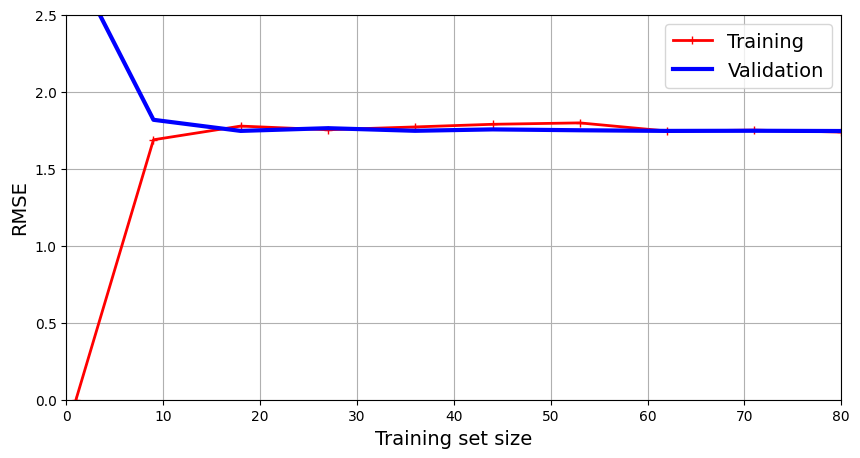

In [64]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 10), cv=5, scoring='neg_root_mean_squared_error')

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="Training")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="Validation")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.xlim(0, 80)
plt.ylim(0, 2.5)
plt.legend()
plt.grid()
plt.show()

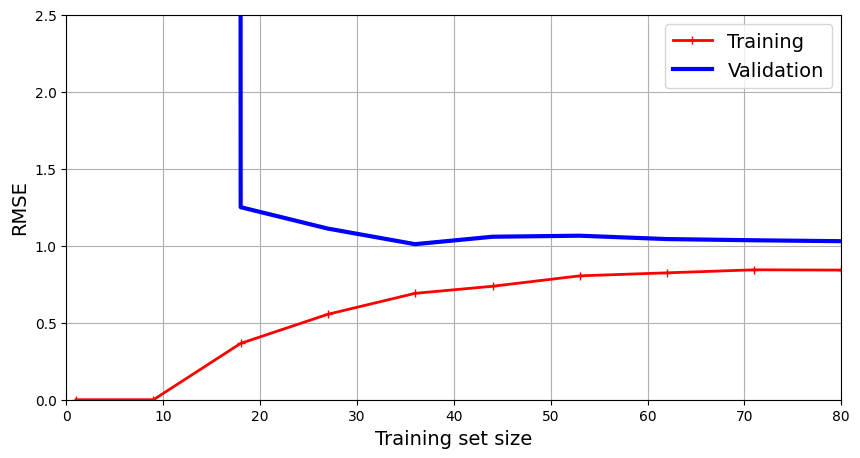

In [65]:
# Compare with a 10th degree polynomial

poly_regression = make_pipeline(
	PolynomialFeatures(degree=10, include_bias=False),
	StandardScaler(),
	LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(poly_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 10), cv=5, scoring='neg_root_mean_squared_error')

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="Training")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="Validation")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.xlim(0, 80)
plt.ylim(0, 2.5)
plt.legend()
plt.grid()
plt.show()

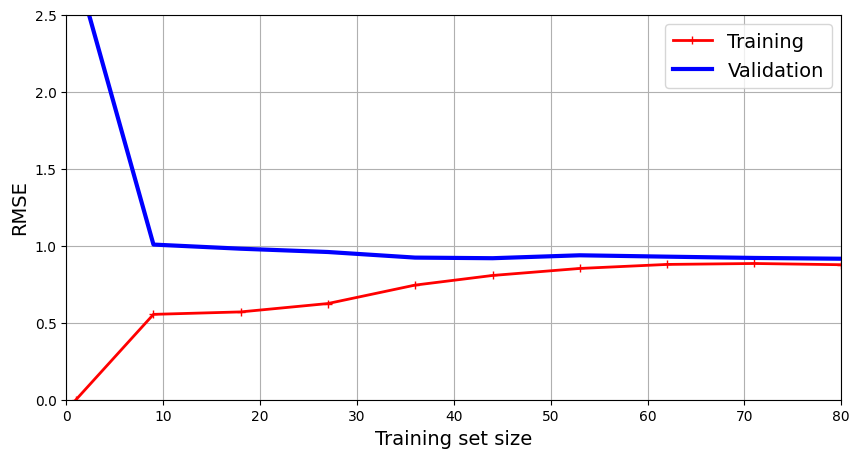

In [66]:
# Compareing with a 2nd degree polynomial

poly_regression = make_pipeline(
	PolynomialFeatures(degree=2, include_bias=False),
	StandardScaler(),
	LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(poly_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 10), cv=5, scoring='neg_root_mean_squared_error')

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="Training")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="Validation")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.xlim(0, 80)
plt.ylim(0, 2.5)
plt.legend()
plt.grid()
plt.show()

# Regularized Linear Models

## Ridge Regression

Adds a regularization term equal to $\alpha/m \cdot \sum\theta^2$ to the cost function.

The cost function for Ridge Regression is:

$J(\theta) = MSE(\theta) + \frac{\alpha}{m} \sum_{i=1}^{n} \theta_i^2$

It tries to keep the weights as small as possible.

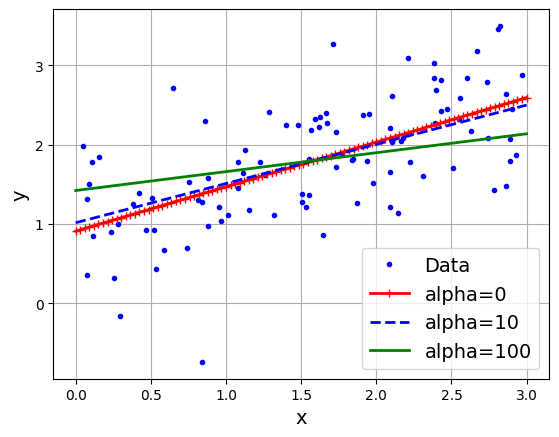

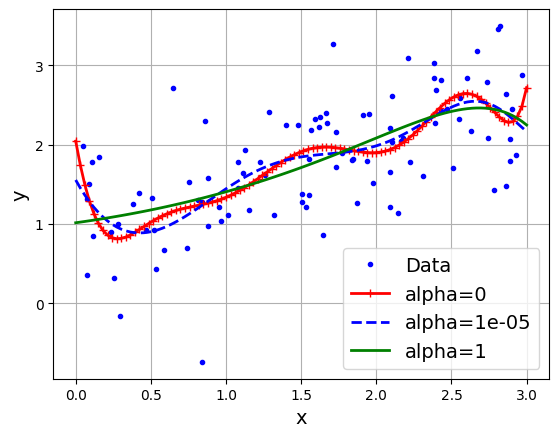

In [67]:
# Some example of ridge regression
from sklearn.linear_model import Ridge

m = 100
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def regularized_models_comparison(X, y, X_new, model_class, degree, alphas, **model_kwargs):
	plt.plot(X, y, "b.", label='Data')

	for alpha, style in zip(alphas, ('r-+', 'b--', 'g-')):
		if alpha > 0:
			model = model_class(alpha=alpha, **model_kwargs)
		else:
			model = LinearRegression()

		if degree is not None:
			model = make_pipeline(
				PolynomialFeatures(degree=degree, include_bias=False),
				StandardScaler(),
				model
			)

		model.fit(X, y)
		y_preds = model.predict(X_new)
		plt.plot(X_new, y_preds, style, linewidth=2, label=f'alpha={alpha}')

	plt.xlabel('x')
	plt.ylabel('y')
	plt.grid()
	plt.legend()
	plt.show()

alphas = (0, 10, 100)
regularized_models_comparison(X, y, X_new, Ridge, None, alphas=alphas)
regularized_models_comparison(X, y, X_new, Ridge, 10, alphas=(0, 1e-5, 1))

Closed form solution for Ridge Regression:

$\hat{\theta} = (X^T \cdot X + \alpha A)^{-1} \cdot X^T \cdot y$

Where A is the identity matrix with a 0 in the top-left cell.

## Lasso Regression

Adds a regularization term equal to $2\alpha \cdot \sum|\theta|$ to the cost function.

The cost function for Lasso Regression is:

$J(\theta) = MSE(\theta) + \frac{\alpha}{m} \sum_{i=1}^{n} |\theta_i|$

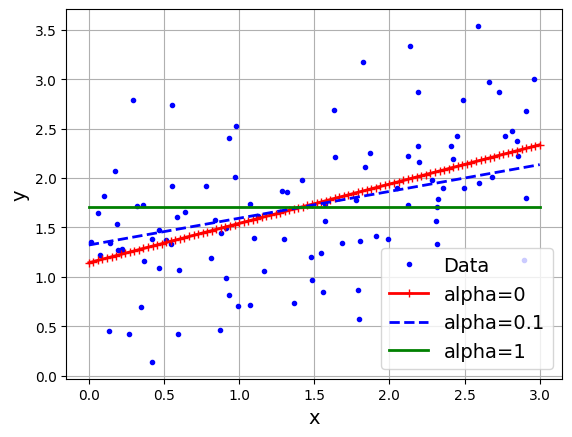

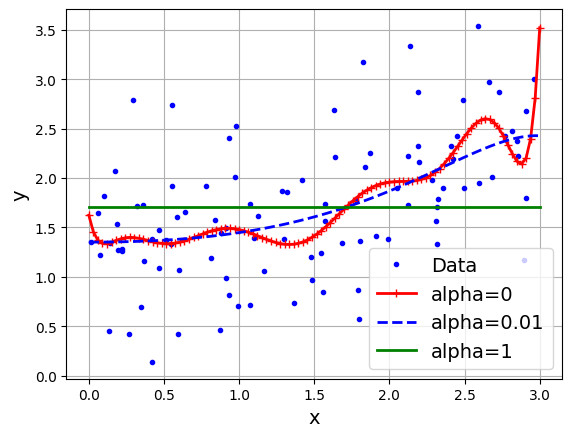

In [68]:
# Example of Lasso regression

from sklearn.linear_model import Lasso

np.random.seed(42)
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

alphas = (0, 0.1, 1)
regularized_models_comparison(X, y, X_new, Lasso, None, alphas=alphas)
regularized_models_comparison(X, y, X_new, Lasso, 10, alphas=(0, 0.01, 1))

## Elastic Net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression.

The cost function for Elastic Net is:

$J(\theta) = MSE(\theta) + r \left( 2\alpha \sum_{i=1}^{n} |\theta_i| \right) + (1-r)  \left( \alpha \sum_{i=1}^{n} \theta_i^2 \right)$

Where r is the mix ratio. r = 0 is Ridge Regression, r = 1 is Lasso Regression.

In [69]:
# Simple use of Elastic Net
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
# l1_ratio corresponds to the mix ratio r
# r = 0: Ridge; r = 1: Lasso

elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.73268344])

## Early Stopping

Stop training as soon as the validation error reaches a minimum.

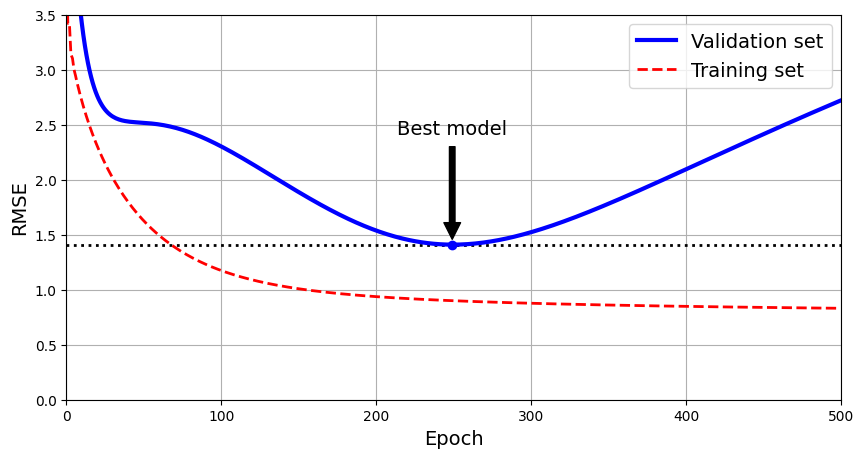

In [70]:
# Example of early stopping
from copy import deepcopy
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

preprocessing = make_pipeline(
	PolynomialFeatures(degree=90, include_bias=False),
	StandardScaler()
)

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, valid_errors = [], []

for epoch in range(n_epochs):
	sgd_reg.partial_fit(X_train_prep, y_train)
	y_valid_pred = sgd_reg.predict(X_valid_prep)
	val_error = root_mean_squared_error(y_valid, y_valid_pred)
	if val_error < best_valid_rmse:
		best_valid_rmse = val_error
		best_model = deepcopy(sgd_reg)
		best_epoch = epoch

	y_train_pred = sgd_reg.predict(X_train_prep)
	train_errors.append(root_mean_squared_error(y_train, y_train_pred))
	valid_errors.append(val_error)

plt.figure(figsize=(10, 5))
plt.annotate('Best model',
			 xy=(best_epoch, best_valid_rmse),
			 xytext=(best_epoch, best_valid_rmse + 1),
			 ha = 'center',
			 arrowprops=dict(facecolor='black', shrink=0.05),
			 fontsize=14
			 )
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(valid_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()

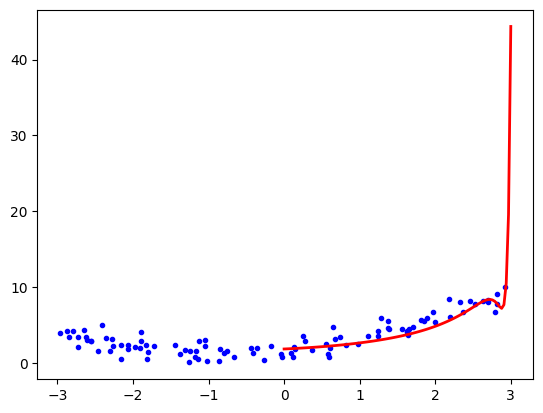

In [71]:
plt.plot(X, y, "b.")
plt.plot(X_new, best_model.predict(preprocessing.transform(X_new)), "r-", linewidth=2, label="Best model")

## Logistic Regression

Text(0, 0.5, '$\\sigma(z)$')

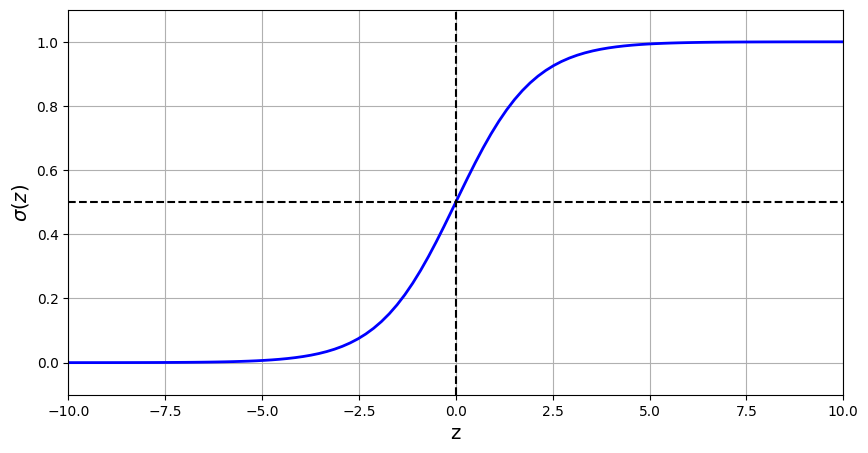

In [72]:
# Plot a sigmoid function
def sigmoid(z):
	return 1 / (1 + np.exp(-z))

z = np.linspace(-10, 10, 100)
plt.figure(figsize=(10, 5))
plt.plot(z, sigmoid(z), "b-", linewidth=2)
plt.vlines(0, -0.1, 1.1, colors='k', linestyles='dashed')
plt.hlines(0.5, -10, 10, colors='k', linestyles='dashed')
plt.axis([-10, 10, -0.1, 1.1])
plt.grid()
plt.xlabel("z")
plt.ylabel("$\\sigma(z)$")

Using logistic regression to classify data. 
If the estimated probability is greater than 0.5, the model predicts 1, otherwise it predicts 0.

The cost function for a single instance is:

$$
J(\theta) = \left \{
\begin{array}{ll}
-log(\hat{p}) & \text{if } y = 1 \\
-log(1 - \hat{p}) & \text{if } y = 0
\end{array}
\right.
$$

$\hat{p}$ is the estimated probability that the instance is positive. 

Note that when $y = 1$, the cost function $-log(\hat{p})$ grows very large as $\hat{p}$ approaches 0 and approaches 0 as $\hat{p}$ approaches 1.

When $y = 0$, the cost function $-log(1 - \hat{p})$ grows very large as $\hat{p}$ approaches 1 and approaches 0 as $\hat{p}$ approaches 0.

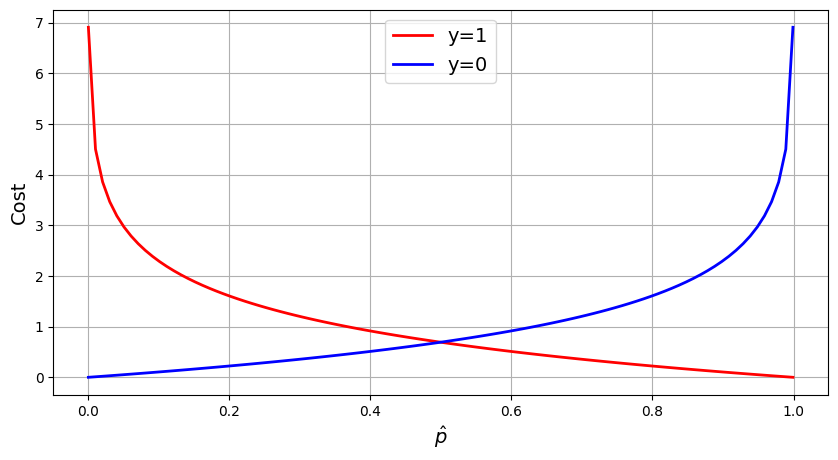

In [84]:
# Plot the cost functions for logistic regression
def log_reg_cost_plot():
	tol = 1e-3
	t = np.linspace(0+tol, 1-tol, 100)
	plt.figure(figsize=(10, 5))
	plt.plot(t, -np.log(t), "r-", linewidth=2, label="y=1")
	plt.plot(t, -np.log(1 - t), "b-", linewidth=2, label="y=0")
	plt.xlabel("$\\hat{p}$")
	plt.ylabel("Cost")
	plt.grid()
	plt.legend()
	plt.show()

log_reg_cost_plot()

The cost function over the whole training set is the average of the cost function for each instance. It can be written as:

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \cdot log(\hat{p}^{(i)}) + (1 - y^{(i)}) \cdot log(1 - \hat{p}^{(i)}) \right]
$$

Note:

- Proof: Bayesion Inference
	
- This cost function assumes that the instances follow a Gaussian distribution around the mean of their class.



## Decision Boundaries

Using the iris set to train a logistic regression model to classify the Iris-Virginica type based on the petal width feature.

In [97]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [100]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [98]:
iris.data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [101]:
print(iris.target_names)
# Not shuffled
iris.target.head()

['setosa' 'versicolor' 'virginica']


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int32

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = iris.data[["petal width (cm)"]].values
Y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

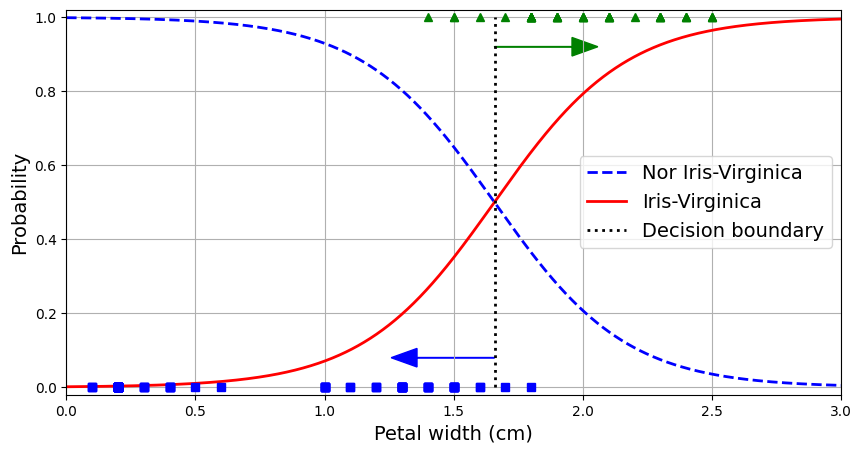

In [120]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(10, 5))
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Nor Iris-Virginica")
plt.plot(X_new, y_proba[:, 1], "r-", linewidth=2, label="Iris-Virginica")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2, label="Decision boundary")

plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")

# Plot blue squares for non-virginica and green triangles for virginica
# X position is the petal width, Y position is the probability of being virginica
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()
plt.legend()
plt.show()

In [121]:
decision_boundary

1.6576576576576576

In [124]:
# Over the decision boundary, the probability of being virginica over 0.5
log_reg.predict([[1.7], [1.6]])

array([ True, False])

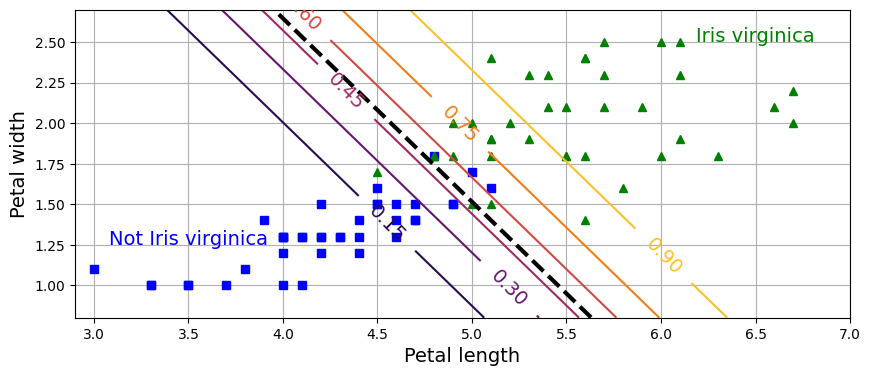

In [146]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
			 /log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
# y_train == 0 ==> Not virginica
# X_train[0] = petal length; X_train[1] = petal width
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.inferno)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.25, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.5, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

## Softmax Regression

In [147]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [152]:
some_petal = [[5, 2]]
softmax_reg.predict(some_petal)

array([2])

In [155]:
softmax_reg.predict_proba(some_petal).round(2)

array([[0.  , 0.04, 0.96]])

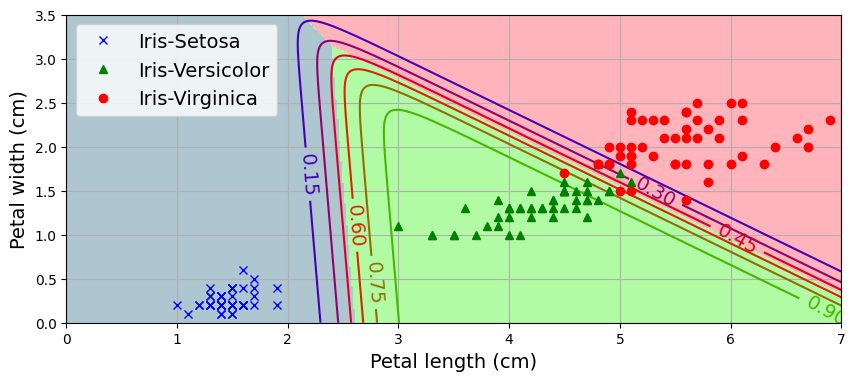

In [188]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 4))

custom_cmap = ListedColormap(["#AEC6CF", "#B2FBA5", "#FFB3BA"])
x0, x1 = np.meshgrid(
	np.linspace(0, 8, 500).reshape(-1, 1),
	np.linspace(0, 3.5, 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)


plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(X[y == 0, 0], X[y == 0, 1], "bx", label="Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "g^", label="Iris-Versicolor")
plt.plot(X[y == 2, 0], X[y == 2, 1], "ro", label="Iris-Virginica")
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.xlim(0, 7)
plt.ylim(0, 3.5)
plt.legend()
plt.grid()